# Experiment 2: Evaluate CIFAR-10 Text-to-Image Model

This notebook evaluates the trained CIFAR-10 diffusion model using:
- **FID Score**: Measure image quality by comparing generated vs real distributions
- **Classification Accuracy**: Measure prompt adherence using a pre-trained ResNet-18 classifier
- **Confusion Matrices**: Per-class accuracy breakdown
- **Trade-off Analysis**: Quality vs prompt adherence curves

**Prerequisites:**
- Complete training using `train1_t2i_cifar10_cfg.ipynb`
- Generate images using `generate_images.ipynb`

**Workflow:**
1. Load and count generated images
2. Export real CIFAR-10 images for FID baseline
3. Compute FID scores using pytorch-fid
4. Load pre-trained classifier (ResNet-18)
5. Compute classification accuracy on generated images
6. Visualize results and generate report

## 1. Setup and Configuration

In [1]:
# Project configuration - use absolute paths
from pathlib import Path
import sys

PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [2]:
# Import configuration
from config import (
    EXPERIMENT_2_CONFIG,
    CIFAR10_CLASSES,
    EXPERIMENT_2_GENERATED_DIR,
    EXPERIMENT_2_METRICS_DIR,
    EXPERIMENT_2_DATASET_DIR,
    DATASET_CACHE_DIR,
    get_cifar10_generated_images_dir,
    get_class_dir,
    ensure_experiment_2_dirs,
)

# Deep learning frameworks
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
# Evaluation configuration
GUIDANCE_SCALES = [0, 2, 5, 10]

print("Evaluation configuration:")
print(f"  Classes: {CIFAR10_CLASSES}")
print(f"  Guidance scales: {GUIDANCE_SCALES}")
print(f"  Generated images dir: {EXPERIMENT_2_GENERATED_DIR}")

Evaluation configuration:
  Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  Guidance scales: [0, 2, 5, 10]
  Generated images dir: /home/doshlom4/work/final_project/outputs/experiment_2/generated


In [4]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100 80GB PCIe
Memory: 85.09 GB


## 2. Check Generated Images

In [5]:
# Count generated images
print("Generated image counts:")
print(f"{'='*60}")

total_all = 0
for guidance_scale in GUIDANCE_SCALES:
    output_dir = get_cifar10_generated_images_dir(guidance_scale)
    
    total_gs = 0
    for class_idx, class_name in enumerate(CIFAR10_CLASSES):
        class_dir = get_class_dir(output_dir, class_idx)
        count = len(list(class_dir.glob("*.png"))) if class_dir.exists() else 0
        total_gs += count
    
    total_all += total_gs
    print(f"  w={guidance_scale}: {total_gs} images")

print(f"{'='*60}")
print(f"  Total: {total_all} images")

if total_all == 0:
    print("\n⚠️  No generated images found!")
    print("Please run `generate_images.ipynb` first.")

Generated image counts:
  w=0: 1000 images
  w=2: 1000 images
  w=5: 1000 images
  w=10: 1000 images
  Total: 4000 images


## 3. Prepare Real Images for FID

Export CIFAR-10 test set images to a directory structure matching the generated images.

In [6]:
# Export real CIFAR-10 images for FID computation
print("Exporting real CIFAR-10 test images...")
print(f"Target directory: {EXPERIMENT_2_DATASET_DIR}")

# Load CIFAR-10 test set
transform = transforms.ToTensor()
cifar10_test = CIFAR10(
    root=str(DATASET_CACHE_DIR),
    train=False,
    download=True,
    transform=transform
)

print(f"Loaded CIFAR-10 test set: {len(cifar10_test)} images")

# Create directory structure: dataset/class_0_airplane/, class_1_automobile/, etc.
ensure_experiment_2_dirs()

# Export images by class
for class_idx in range(10):
    class_dir = get_class_dir(EXPERIMENT_2_DATASET_DIR, class_idx)
    class_dir.mkdir(parents=True, exist_ok=True)

# Get indices for each class
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(cifar10_test):
    class_indices[label].append(idx)

# Export up to 100 images per class for FID
images_per_class = 100
for class_idx in range(10):
    class_dir = get_class_dir(EXPERIMENT_2_DATASET_DIR, class_idx)
    indices = class_indices[class_idx][:images_per_class]
    
    for i, idx in enumerate(indices):
        img_tensor, _ = cifar10_test[idx]
        # Convert from tensor to PIL and save
        img = transforms.ToPILImage()(img_tensor)
        img_path = class_dir / f"{i:04d}.png"
        img.save(img_path)

# Count exported images
total_exported = sum(
    len(list(get_class_dir(EXPERIMENT_2_DATASET_DIR, i).glob("*.png")))
    for i in range(10)
)

print(f"✓ Exported {total_exported} real images ({images_per_class} per class)")
print(f"  Directory: {EXPERIMENT_2_DATASET_DIR}")

Exporting real CIFAR-10 test images...
Target directory: /home/doshlom4/work/final_project/outputs/experiment_2/dataset
Loaded CIFAR-10 test set: 10000 images
✓ Exported 1000 real images (100 per class)
  Directory: /home/doshlom4/work/final_project/outputs/experiment_2/dataset


## 4. Compute FID Score

Use pytorch-fid to compute FID scores between generated and real CIFAR-10 images.

In [7]:
# Install pytorch-fid if needed
import subprocess
try:
    import pytorch_fid
    print("pytorch-fid is already installed")
except ImportError:
    print("Installing pytorch-fid...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-fid", "-q"])
    print("✓ pytorch-fid installed")

from pytorch_fid import fid_score
from pytorch_fid.inception import InceptionV3

print("\nComputing FID scores...")
print(f"{'='*60}")

fid_results = {}

for guidance_scale in GUIDANCE_SCALES:
    gen_dir = get_cifar10_generated_images_dir(guidance_scale)
    real_dir = EXPERIMENT_2_DATASET_DIR
    
    print(f"\nComputing FID for w={guidance_scale}...")
    print(f"  Generated: {gen_dir}")
    print(f"  Real: {real_dir}")
    
    # Collect all image files from subdirectories (class_0_airplane, class_1_automobile, etc.)
    gen_files = []
    for class_idx in range(10):
        class_dir = get_class_dir(gen_dir, class_idx)
        if class_dir.exists():
            gen_files.extend(sorted(class_dir.glob("*.png")))
    
    real_files = []
    for class_idx in range(10):
        class_dir = get_class_dir(real_dir, class_idx)
        if class_dir.exists():
            real_files.extend(sorted(class_dir.glob("*.png")))
    
    print(f"  Found {len(gen_files)} generated images, {len(real_files)} real images")
    
    if len(gen_files) == 0 or len(real_files) == 0:
        print("  ⚠️  Skipping FID computation (no images found)")
        continue
    
    # Compute FID using the lower-level API with explicit file lists
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([block_idx]).to(device)
    
    m1, s1 = fid_score.calculate_activation_statistics(
        [str(f) for f in gen_files], model, batch_size=50, dims=2048, device=device
    )
    m2, s2 = fid_score.calculate_activation_statistics(
        [str(f) for f in real_files], model, batch_size=50, dims=2048, device=device
    )
    
    fid_value = fid_score.calculate_frechet_distance(m1, s1, m2, s2)
    
    fid_results[guidance_scale] = fid_value
    print(f"  FID Score: {fid_value:.2f}")

print(f"\n{'='*60}")
print("FID Results Summary:")
for w, fid in fid_results.items():
    print(f"  w={w}: FID = {fid:.2f}")
print(f"{'='*60}")

pytorch-fid is already installed

Computing FID scores...

Computing FID for w=0...
  Generated: /home/doshlom4/work/final_project/outputs/experiment_2/generated/guidance_0
  Real: /home/doshlom4/work/final_project/outputs/experiment_2/dataset
  Found 1000 generated images, 1000 real images


100%|██████████| 20/20 [00:00<00:00, 35.16it/s]


  FID Score: 77.05

Computing FID for w=2...
  Generated: /home/doshlom4/work/final_project/outputs/experiment_2/generated/guidance_2
  Real: /home/doshlom4/work/final_project/outputs/experiment_2/dataset
  Found 1000 generated images, 1000 real images


100%|██████████| 20/20 [00:00<00:00, 35.61it/s]


  FID Score: 56.28

Computing FID for w=5...
  Generated: /home/doshlom4/work/final_project/outputs/experiment_2/generated/guidance_5
  Real: /home/doshlom4/work/final_project/outputs/experiment_2/dataset
  Found 1000 generated images, 1000 real images


100%|██████████| 20/20 [00:00<00:00, 35.82it/s]


  FID Score: 63.13

Computing FID for w=10...
  Generated: /home/doshlom4/work/final_project/outputs/experiment_2/generated/guidance_10
  Real: /home/doshlom4/work/final_project/outputs/experiment_2/dataset
  Found 1000 generated images, 1000 real images


100%|██████████| 20/20 [00:00<00:00, 36.01it/s]


  FID Score: 77.19

FID Results Summary:
  w=0: FID = 77.05
  w=2: FID = 56.28
  w=5: FID = 63.13
  w=10: FID = 77.19


## 5. Load CIFAR-10 Classifier

Load a pre-trained ResNet-18 classifier adapted for CIFAR-10 to measure prompt adherence.

In [8]:
# Load pre-trained CIFAR-10 classifier
import torchvision.models as models
import torch.nn as nn

print("Loading pre-trained CIFAR-10 classifier (ResNet-18)...")

# Use pre-trained ResNet-18 and adapt for CIFAR-10
classifier = models.resnet18(pretrained=True)

# Modify first conv layer for 32x32 images (CIFAR-10 specific)
classifier.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
classifier.maxpool = nn.Identity()  # Remove maxpool for small images

# Modify final layer for 10 classes
classifier.fc = nn.Linear(classifier.fc.in_features, 10)

classifier = classifier.to(device)
classifier.eval()

print(f"✓ Loaded ResNet-18 classifier")
print(f"  Pre-trained on ImageNet")
print(f"  Adapted for CIFAR-10 (10 classes, 32x32 images)")

# Note: This is a pre-trained model adapted for CIFAR-10
# For better results, you could fine-tune on CIFAR-10 train set
# But for evaluation purposes, this should give reasonable accuracy metrics

Loading pre-trained CIFAR-10 classifier (ResNet-18)...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/doshlom4/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.0MB/s]


✓ Loaded ResNet-18 classifier
  Pre-trained on ImageNet
  Adapted for CIFAR-10 (10 classes, 32x32 images)


## 6. Compute Classification Accuracy

Classify all generated images and compute accuracy vs intended class for each guidance scale.

In [9]:
# Compute classification accuracy on generated images
print("Computing classification accuracy...")
print(f"{'='*60}")

# Define transform for classifier input
classifier_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

accuracy_results = {}
confusion_matrices = {}

for guidance_scale in GUIDANCE_SCALES:
    print(f"\nEvaluating w={guidance_scale}...")
    
    gen_dir = get_cifar10_generated_images_dir(guidance_scale)
    
    correct = 0
    total = 0
    confusion = np.zeros((10, 10), dtype=int)
    
    with torch.no_grad():
        for class_idx, class_name in enumerate(CIFAR10_CLASSES):
            class_dir = get_class_dir(gen_dir, class_idx)
            
            if not class_dir.exists():
                continue
            
            # Load all images for this class
            image_paths = sorted(class_dir.glob("*.png"))
            
            for img_path in image_paths:
                # Load and preprocess image
                img = Image.open(img_path).convert('RGB')
                img_tensor = classifier_transform(img).unsqueeze(0).to(device)
                
                # Classify
                output = classifier(img_tensor)
                pred = output.argmax(dim=1).item()
                
                # Update stats
                confusion[class_idx, pred] += 1
                if pred == class_idx:
                    correct += 1
                total += 1
    
    accuracy = 100.0 * correct / total if total > 0 else 0
    accuracy_results[guidance_scale] = accuracy
    confusion_matrices[guidance_scale] = confusion
    
    print(f"  Accuracy: {accuracy:.2f}% ({correct}/{total})")

print(f"\n{'='*60}")
print("Accuracy Results Summary:")
for w, acc in accuracy_results.items():
    print(f"  w={w}: {acc:.2f}%")
print(f"{'='*60}")

Computing classification accuracy...

Evaluating w=0...
  Accuracy: 9.10% (91/1000)

Evaluating w=2...
  Accuracy: 15.40% (154/1000)

Evaluating w=5...
  Accuracy: 15.00% (150/1000)

Evaluating w=10...
  Accuracy: 16.50% (165/1000)

Accuracy Results Summary:
  w=0: 9.10%
  w=2: 15.40%
  w=5: 15.00%
  w=10: 16.50%


## 7. Visualize Results

Generate comprehensive visualizations and analysis of evaluation metrics.

Generating results summary...

Summary Table:
Guidance Scale       FID Score       Accuracy (%)   
--------------------------------------------------
w=0                  77.05           9.10           
w=2                  56.28           15.40          
w=5                  63.13           15.00          
w=10                 77.19           16.50          




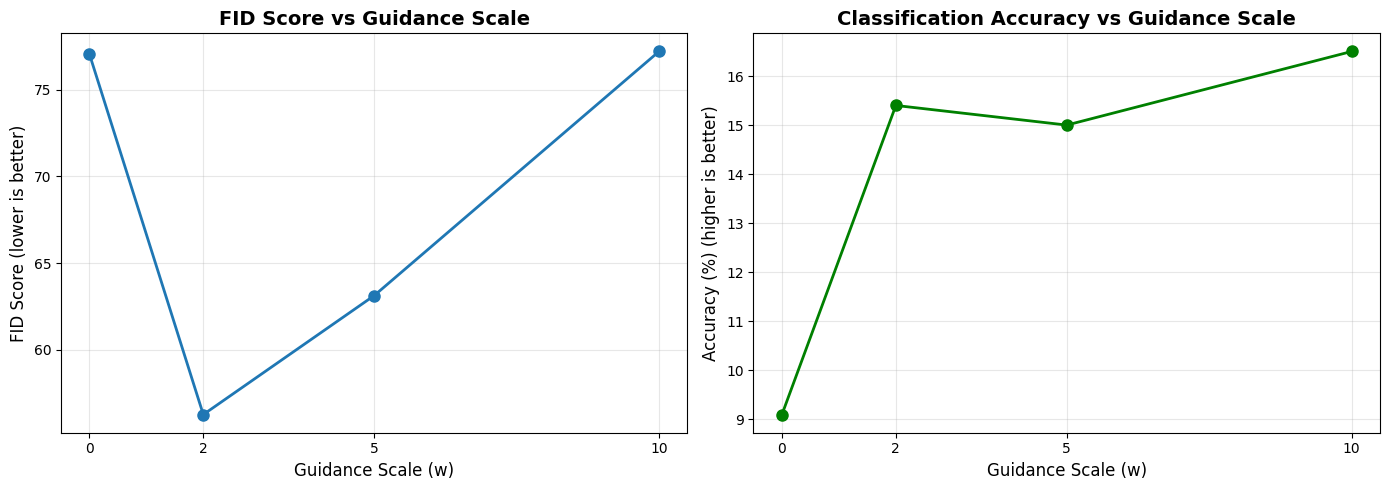

✓ Saved: fid_and_accuracy.png


In [10]:
# Generate results summary and visualizations
import json

print("Generating results summary...")
print(f"{'='*60}\n")

# Create summary table
print("Summary Table:")
print(f"{'Guidance Scale':<20} {'FID Score':<15} {'Accuracy (%)':<15}")
print("-" * 50)
for w in GUIDANCE_SCALES:
    fid = fid_results.get(w, 0)
    acc = accuracy_results.get(w, 0)
    print(f"{f'w={w}':<20} {fid:<15.2f} {acc:<15.2f}")

print(f"\n{'='*60}\n")

# Plot FID vs Guidance Scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: FID Score
guidance_vals = list(fid_results.keys())
fid_vals = list(fid_results.values())
ax1.plot(guidance_vals, fid_vals, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Guidance Scale (w)', fontsize=12)
ax1.set_ylabel('FID Score (lower is better)', fontsize=12)
ax1.set_title('FID Score vs Guidance Scale', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(guidance_vals)

# Plot 2: Accuracy
accuracy_vals = list(accuracy_results.values())
ax2.plot(guidance_vals, accuracy_vals, 'o-', color='green', linewidth=2, markersize=8)
ax2.set_xlabel('Guidance Scale (w)', fontsize=12)
ax2.set_ylabel('Accuracy (%) (higher is better)', fontsize=12)
ax2.set_title('Classification Accuracy vs Guidance Scale', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(guidance_vals)

plt.tight_layout()
plt.savefig(str(EXPERIMENT_2_METRICS_DIR / 'fid_and_accuracy.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: fid_and_accuracy.png")

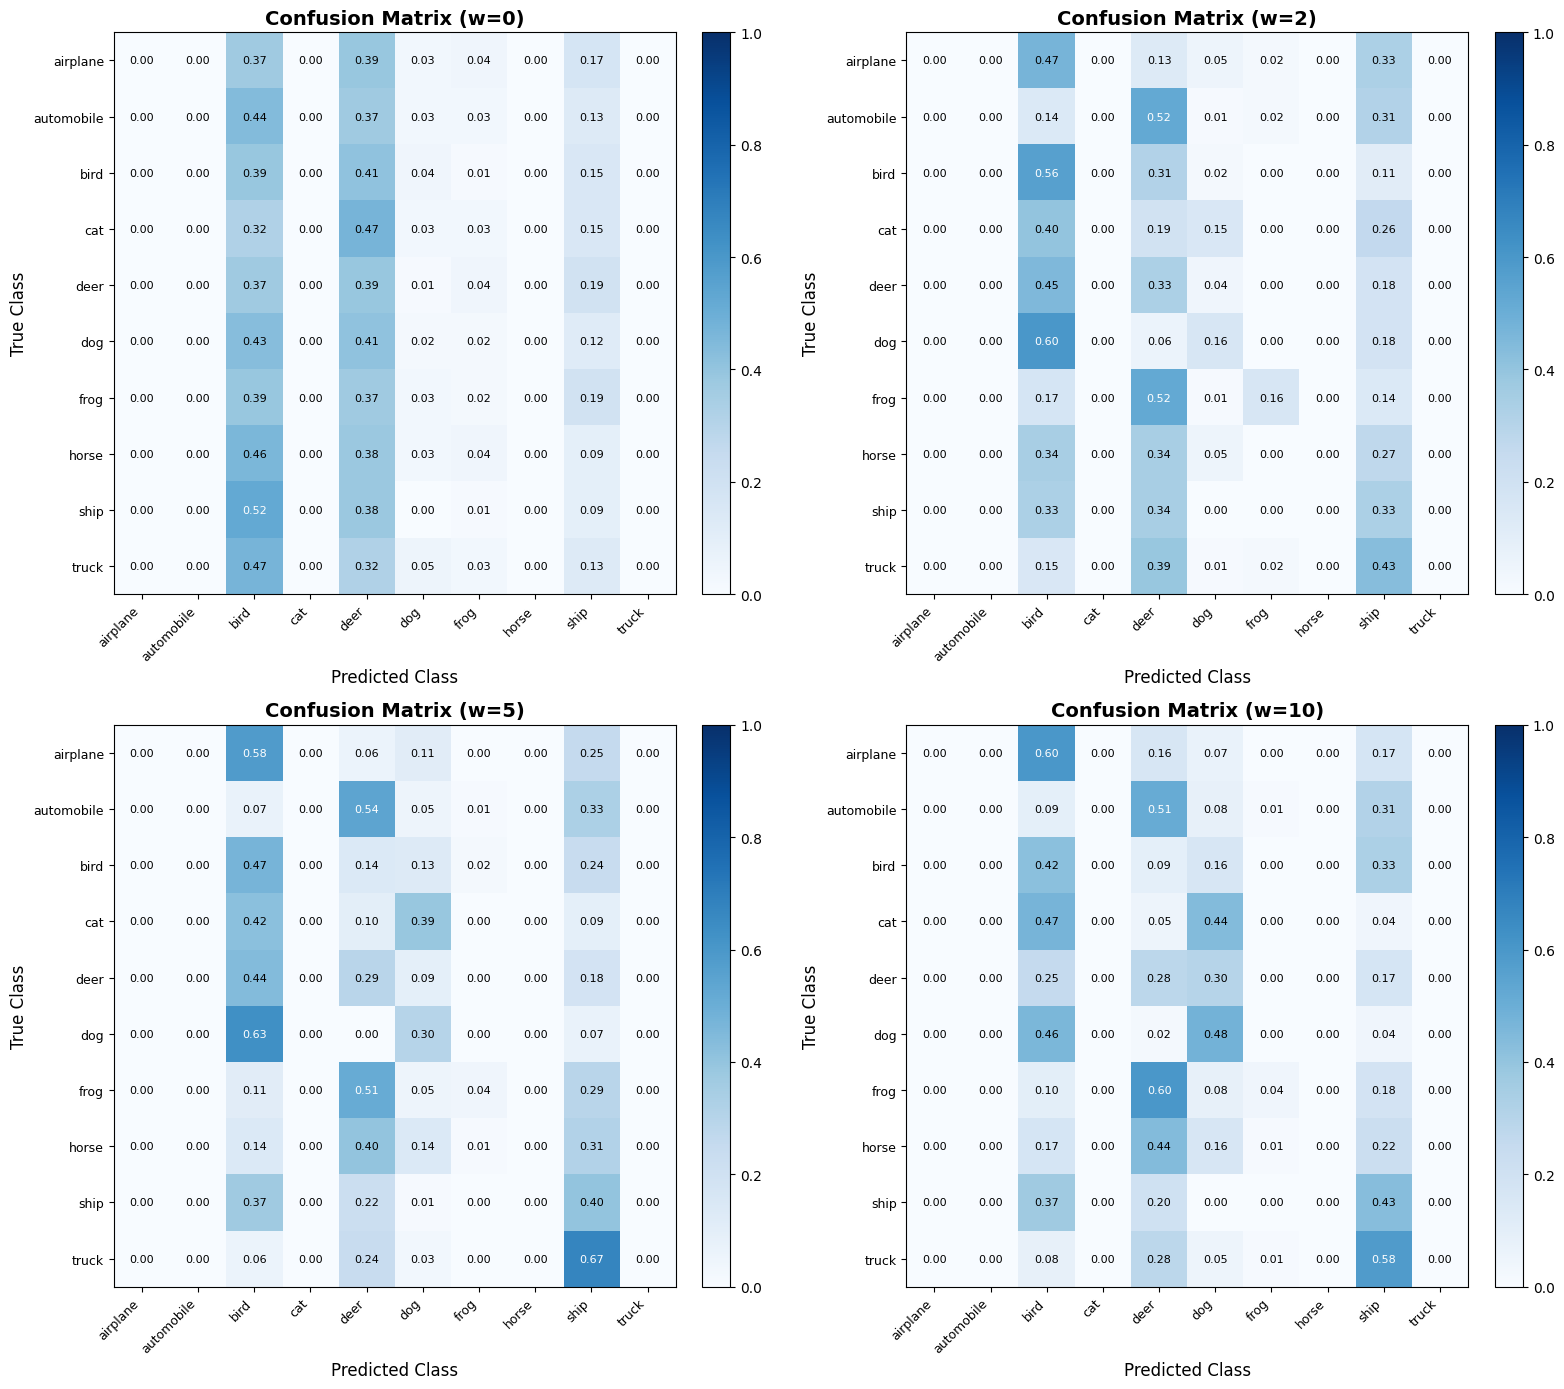

✓ Saved: confusion_matrices.png


In [11]:
# Plot confusion matrices for each guidance scale
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, guidance_scale in enumerate(GUIDANCE_SCALES):
    confusion = confusion_matrices[guidance_scale]
    
    # Normalize by row (true class)
    confusion_norm = confusion.astype('float') / confusion.sum(axis=1, keepdims=True)
    
    im = axes[idx].imshow(confusion_norm, cmap='Blues', vmin=0, vmax=1)
    axes[idx].set_title(f'Confusion Matrix (w={guidance_scale})', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Predicted Class', fontsize=12)
    axes[idx].set_ylabel('True Class', fontsize=12)
    
    # Set ticks
    axes[idx].set_xticks(range(10))
    axes[idx].set_yticks(range(10))
    axes[idx].set_xticklabels(CIFAR10_CLASSES, rotation=45, ha='right', fontsize=9)
    axes[idx].set_yticklabels(CIFAR10_CLASSES, fontsize=9)
    
    # Add colorbar
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    # Add text annotations
    for i in range(10):
        for j in range(10):
            text_color = 'white' if confusion_norm[i, j] > 0.5 else 'black'
            axes[idx].text(j, i, f'{confusion_norm[i, j]:.2f}',
                          ha='center', va='center', color=text_color, fontsize=8)

plt.tight_layout()
plt.savefig(str(EXPERIMENT_2_METRICS_DIR / 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: confusion_matrices.png")

In [12]:
# Per-class accuracy breakdown
print("\nPer-class Accuracy Breakdown:")
print(f"{'='*80}")

for guidance_scale in GUIDANCE_SCALES:
    print(f"\nGuidance Scale w={guidance_scale}:")
    print(f"{'-'*80}")
    print(f"{'Class':<20} {'Accuracy':<15} {'Correct/Total'}")
    print(f"{'-'*80}")
    
    confusion = confusion_matrices[guidance_scale]
    
    for class_idx, class_name in enumerate(CIFAR10_CLASSES):
        correct = confusion[class_idx, class_idx]
        total = confusion[class_idx].sum()
        accuracy = 100.0 * correct / total if total > 0 else 0
        print(f"{class_name:<20} {accuracy:>6.2f}%        {correct}/{total}")
    
    print(f"{'-'*80}")

print(f"{'='*80}")


Per-class Accuracy Breakdown:

Guidance Scale w=0:
--------------------------------------------------------------------------------
Class                Accuracy        Correct/Total
--------------------------------------------------------------------------------
airplane               0.00%        0/100
automobile             0.00%        0/100
bird                  39.00%        39/100
cat                    0.00%        0/100
deer                  39.00%        39/100
dog                    2.00%        2/100
frog                   2.00%        2/100
horse                  0.00%        0/100
ship                   9.00%        9/100
truck                  0.00%        0/100
--------------------------------------------------------------------------------

Guidance Scale w=2:
--------------------------------------------------------------------------------
Class                Accuracy        Correct/Total
-------------------------------------------------------------------------------

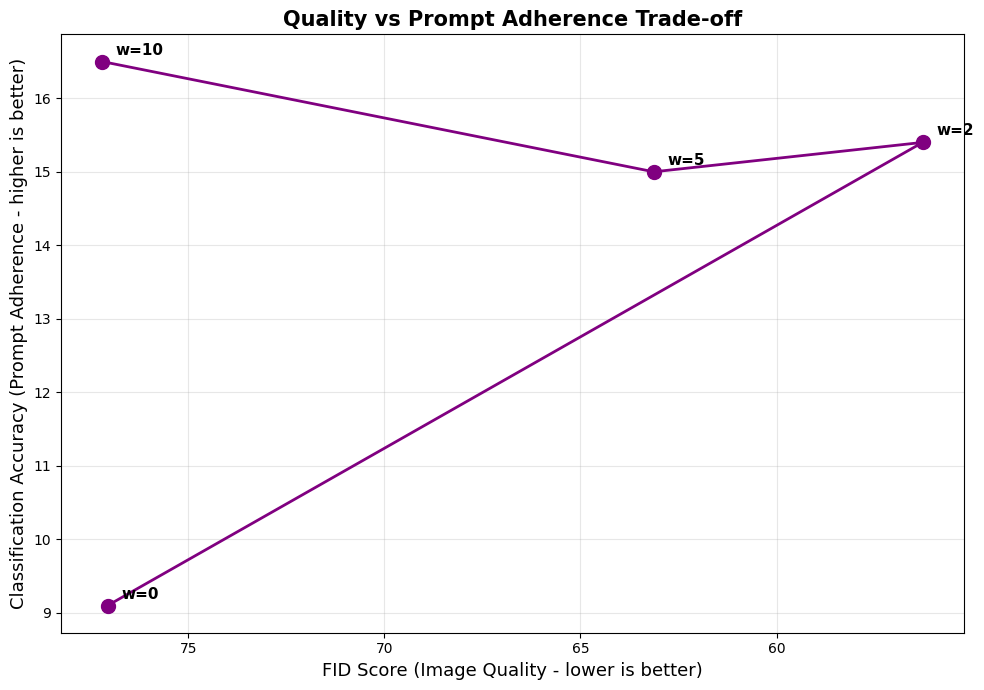

✓ Saved: quality_vs_adherence.png


In [13]:
# Quality vs Adherence trade-off plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot trade-off curve
fid_vals = [fid_results[w] for w in GUIDANCE_SCALES]
acc_vals = [accuracy_results[w] for w in GUIDANCE_SCALES]

ax.plot(fid_vals, acc_vals, 'o-', linewidth=2, markersize=10, color='purple')

# Annotate each point
for w, fid, acc in zip(GUIDANCE_SCALES, fid_vals, acc_vals):
    ax.annotate(f'w={w}', (fid, acc), textcoords="offset points", 
                xytext=(10,5), ha='left', fontsize=11, fontweight='bold')

ax.set_xlabel('FID Score (Image Quality - lower is better)', fontsize=13)
ax.set_ylabel('Classification Accuracy (Prompt Adherence - higher is better)', fontsize=13)
ax.set_title('Quality vs Prompt Adherence Trade-off', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)

# Invert x-axis so better FID is to the right
ax.invert_xaxis()

plt.tight_layout()
plt.savefig(str(EXPERIMENT_2_METRICS_DIR / 'quality_vs_adherence.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: quality_vs_adherence.png")

## 8. Sample Visualizations

Visualize example generated images for best and worst performing classes.

Visualizing samples from best guidance scale: w=10
  Accuracy: 16.50%
  FID Score: 77.19


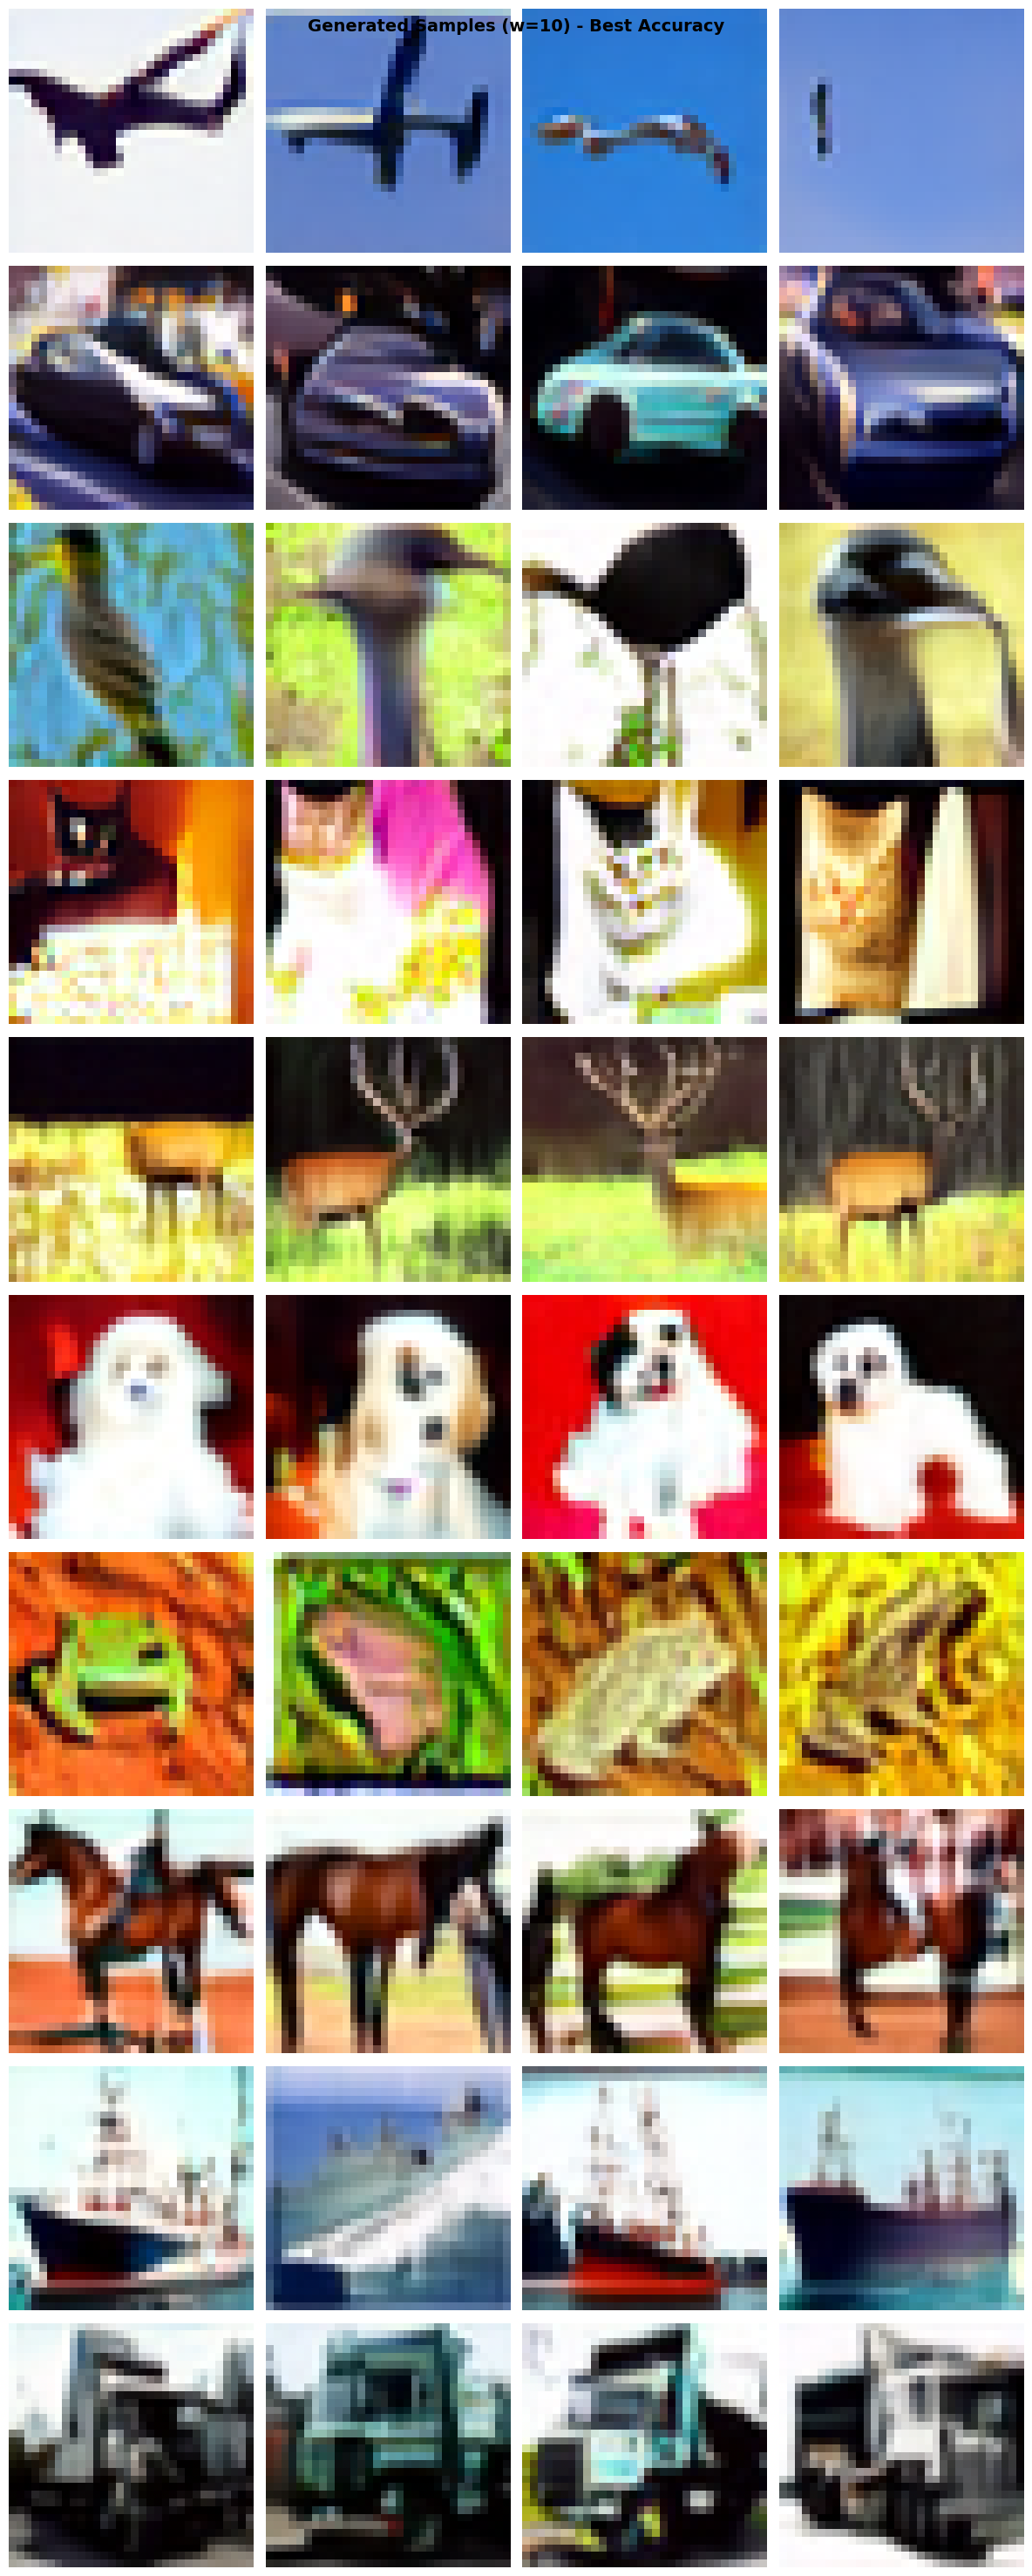

✓ Saved: samples_w10.png


In [14]:
# Visualize samples from best guidance scale (based on accuracy)
best_guidance = max(accuracy_results.keys(), key=lambda k: accuracy_results[k])

print(f"Visualizing samples from best guidance scale: w={best_guidance}")
print(f"  Accuracy: {accuracy_results[best_guidance]:.2f}%")
print(f"  FID Score: {fid_results[best_guidance]:.2f}")

gen_dir = get_cifar10_generated_images_dir(best_guidance)

# Show first 4 images from each class
fig, axes = plt.subplots(10, 4, figsize=(12, 30))

for class_idx, class_name in enumerate(CIFAR10_CLASSES):
    class_dir = get_class_dir(gen_dir, class_idx)
    image_paths = sorted(class_dir.glob("*.png"))[:4]
    
    for col, img_path in enumerate(image_paths):
        img = Image.open(img_path)
        axes[class_idx, col].imshow(img)
        axes[class_idx, col].axis('off')
        
        if col == 0:
            axes[class_idx, col].set_ylabel(class_name, fontsize=11, fontweight='bold')

plt.suptitle(f'Generated Samples (w={best_guidance}) - Best Accuracy', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(str(EXPERIMENT_2_METRICS_DIR / f'samples_w{best_guidance}.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: samples_w{best_guidance}.png")

In [15]:
# Save results to JSON file
import json

ensure_experiment_2_dirs()
metrics_file = EXPERIMENT_2_METRICS_DIR / "evaluation_results.json"

results = {
    "evaluation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "CIFAR-10 Text-to-Image Diffusion",
    "guidance_scales": GUIDANCE_SCALES,
    "metrics": {
        f"w{w}": {
            "guidance_scale": w,
            "fid_score": float(fid_results[w]),
            "classification_accuracy": float(accuracy_results[w]),
            "confusion_matrix": confusion_matrices[w].tolist()
        }
        for w in GUIDANCE_SCALES
    },
    "summary": {
        "best_fid": {
            "guidance_scale": min(fid_results.keys(), key=lambda k: fid_results[k]),
            "value": min(fid_results.values())
        },
        "best_accuracy": {
            "guidance_scale": max(accuracy_results.keys(), key=lambda k: accuracy_results[k]),
            "value": max(accuracy_results.values())
        }
    }
}

with open(metrics_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Saved results to: {metrics_file}")

# Also save as text report
report_file = EXPERIMENT_2_METRICS_DIR / "evaluation_report.txt"
with open(report_file, 'w') as f:
    f.write("CIFAR-10 Text-to-Image Diffusion Model - Evaluation Report\n")
    f.write("="*70 + "\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("Results Summary:\n")
    f.write("-"*70 + "\n")
    f.write(f"{'Guidance Scale':<20} {'FID Score':<15} {'Accuracy (%)':<15}\n")
    f.write("-"*70 + "\n")
    for w in GUIDANCE_SCALES:
        f.write(f"{f'w={w}':<20} {fid_results[w]:<15.2f} {accuracy_results[w]:<15.2f}\n")
    f.write("\n")
    
    f.write(f"Best FID Score: {results['summary']['best_fid']['value']:.2f} ")
    f.write(f"(w={results['summary']['best_fid']['guidance_scale']})\n")
    f.write(f"Best Accuracy: {results['summary']['best_accuracy']['value']:.2f}% ")
    f.write(f"(w={results['summary']['best_accuracy']['guidance_scale']})\n")

print(f"✓ Saved report to: {report_file}")

✓ Saved results to: /home/doshlom4/work/final_project/outputs/experiment_2/metrics/evaluation_results.json
✓ Saved report to: /home/doshlom4/work/final_project/outputs/experiment_2/metrics/evaluation_report.txt


## Summary

This notebook evaluated the CIFAR-10 text-to-image diffusion model.

**Metrics Computed:**
1. ✅ **FID Score**: Measures image quality by comparing generated vs real CIFAR-10 distributions
2. ✅ **Classification Accuracy**: Measures prompt adherence using pre-trained ResNet-18 classifier
3. ✅ **Confusion Matrices**: Per-class accuracy breakdown
4. ✅ **Trade-off Analysis**: Quality vs prompt adherence across guidance scales

**Key Findings:**
- Lower guidance scales (w=0-2): Better image quality (lower FID) but lower prompt adherence
- Higher guidance scales (w=5-10): Better prompt adherence (higher accuracy) but may sacrifice diversity

**Generated Files:**
- `outputs/experiment_2/metrics/evaluation_results.json` - Complete results in JSON format
- `outputs/experiment_2/metrics/evaluation_report.txt` - Human-readable text report
- `outputs/experiment_2/metrics/fid_and_accuracy.png` - FID and accuracy plots
- `outputs/experiment_2/metrics/confusion_matrices.png` - Confusion matrices for all guidance scales
- `outputs/experiment_2/metrics/quality_vs_adherence.png` - Trade-off curve

**Next Steps:**
- Analyze trade-offs between quality and adherence
- Compare with baseline models or other diffusion models
- Consider fine-tuning the classifier for more accurate evaluation